In [1]:
# Imports
import numpy as np
import pandas as pd
import scipy.io as sio
import multiprocessing as mp
import os
import time
import statsmodels.api as sm
from scipy.stats import t as tstat
import matplotlib.pyplot as plt
import torch
from torch.nn import Sequential
from torch import nn
import torch.nn.functional as F
from torch import optim
from random import shuffle
from torchsummary import summary
from torch.autograd import Variable
import math
import tensorflow as tf
import statsmodels.api as sm
from scipy.stats import t as tstat

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('Using device:', device)
# print()

device = torch.device('cpu')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip3 install pickle5
import pickle5 as pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 7.8 MB/s 


In [7]:
with open('/content/drive/MyDrive/df_yield.pkl', "rb") as fh:
  data = pickle.load(fh)

In [8]:
# with open('/content/drive/MyDrive/df_smooth_yield.pkl', "rb") as fh:
#   data = pickle.load(fh)

In [9]:
data

,Date,1m,2m,3m,4m,5m,6m,7m,8m,9m,...,351m,352m,353m,354m,355m,356m,357m,358m,359m,360m
124,1971-01-10,4.112952,4.196824,4.269595,4.328237,4.372741,4.405902,4.432086,4.455566,4.479461,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125,1971-01-11,4.042717,4.133847,4.220581,4.297881,4.363869,4.419226,4.466354,4.508113,4.546714,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126,1971-01-12,3.468110,3.571893,3.678915,3.778655,3.865093,3.936943,3.996833,4.049177,4.098091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127,1972-01-01,3.159769,3.254708,3.355734,3.455842,3.550228,3.636804,3.716271,3.791107,3.864059,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128,1972-01-02,3.171293,3.290726,3.407460,3.518059,3.620338,3.714310,3.802239,3.886925,3.969666,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722,2021-01-08,0.063902,0.067565,0.067938,0.066566,0.064990,0.064375,0.065358,0.068156,0.072781,...,2.006272,2.007011,2.007962,2.009110,2.010436,2.011912,2.013510,2.015206,2.016980,2.018825
723,2021-01-09,0.054318,0.054699,0.054564,0.055030,0.056825,0.060222,0.065116,0.071216,0.078244,...,2.110283,2.110655,2.111127,2.111694,2.112351,2.113092,2.113917,2.114829,2.115839,2.116964
724,2021-01-10,0.058654,0.065824,0.071598,0.077222,0.083769,0.091902,0.101866,0.113690,0.127434,...,1.974639,1.974936,1.975284,1.975683,1.976136,1.976644,1.977211,1.977846,1.978559,1.979364
725,2021-01-11,0.064601,0.069261,0.075924,0.085410,0.098039,0.113730,0.132151,0.152876,0.175458,...,1.826569,1.825037,1.823282,1.821336,1.819247,1.817072,1.814873,1.812719,1.810686,1.808854


In [43]:
df_yield = data
# df_change = data2


# Putting xrets in df
y_excess = np.load('/content/drive/MyDrive/xrets.npy')
y_excess = np.squeeze(y_excess)
y_excess = np.transpose(y_excess)

df_excess = pd.DataFrame(y_excess, index = range(0,591),
             columns=['2y', '3y', '4y', '5y', '7y', '10y'])

Y = df_excess

################ This is for the case with regular yields
X = df_yield.iloc[:-12, 1:121]
X = df_yield.iloc[:,0:120]
X = X.reset_index()
Y = Y.reset_index()

Y = Y.iloc[:,1:]
X = X.iloc[:,1:]


# ################  This is for stationary yield changes
# X = df_change

# # Reset the index so all numbers match
# Y = Y.reset_index()
# X = X.reset_index()

# Y = Y.iloc[:,1:]
# X = X.iloc[:,1:]

# # Smooth excess returns 
# alpha = 0.3
# Y = Y.apply(lambda x:x.shift(1) * alpha + (1-alpha) * x)


# X = X[1:]
# Y = Y[1:]

# ############ Case with smooth yields
X = df_yield

Y = Y.reset_index()
X = X.reset_index()
Y = Y.iloc[:,1:]
X = X.iloc[:,1:]

X = X.iloc[1:,]
Y = Y.iloc[1:,]

# # # # Lagging Y data so no forward looking bias in excess returns
# X = X[1:]
# Y = Y[1:]
Y = Y.shift(1)[1:]
X = X[1:]

# # Working with stationary yields
# # X.loc[len(X.index) + 1] = 0

# Before working must be on 
Y = np.array(Y)
X = np.array(X)

In [44]:
for i in range(6):
  print(np.mean(Y[0:,i]))

0.571440010855691
1.0230088774513497
1.4655411204935054
1.69243429168737
2.1781532498027896
2.584044449628846


,2y,3y,4y,5y,7y,10y
2,0.097346,0.012828,-0.237991,-0.106666,0.437511,-2.041033
3,-0.224676,-0.770867,-1.326938,-1.467363,-0.974783,-1.542689
4,-0.505753,-0.743789,-0.859447,-0.947814,-0.422751,-0.462397
5,-0.957008,-1.651569,-2.066548,-2.524715,-2.519877,-2.014002
6,-0.732397,-1.230759,-1.502376,-1.828475,-2.274812,-3.235600
...,...,...,...,...,...,...
586,0.022557,-0.134058,-0.483341,-1.173911,-2.597491,-5.458500
587,0.045761,-0.111973,-0.515380,-1.226891,-2.390778,-4.390948
588,0.033406,-0.194212,-0.808449,-1.801680,-3.718582,-6.332836
589,-0.003254,-0.537575,-1.274488,-2.235015,-3.723189,-4.995394


#### Preparing accuracy measures and cond mean

In [ ]:
# index_numbers = (np.arange(Y[:,0].shape[0]) + 1)
# index_numbers = index_numbers[:, np.newaxis]

# y_cond_mean = []
# for j in range(6):
#     y_cond_mean.append(np.divide(Y[:,j].cumsum(0)[:,np.newaxis], index_numbers))
#     y_cond_mean[j] = y_cond_mean[j][:-1]
#     y_cond_mean[j] = np.squeeze(y_cond_mean[j])

In [ ]:
index_numbers = (np.arange(Y[:,0].shape[0]) + 1)
index_numbers = index_numbers[:, np.newaxis]

In [ ]:
index_numbers.shape

(589, 1)

In [ ]:
y_cond_mean = np.divide(Y[:,0].cumsum(0)[:,np.newaxis], index_numbers)
y_cond_mean = y_cond_mean[:-1]

In [ ]:
# y_cond_mean

#### Testing R2 measure

In [ ]:
# SSres = np.nansum(np.square(Y_test[0][0:,0] - predictions_test))
# SStot = np.nansum(np.square((Y_test[0][0:,0] - y_cond_mean[-12:])))
# 1 - (SSres/SStot)

In [ ]:
# f = np.square(Y_test[0][0:,0]-y_cond_mean[-12:])-np.square(Y_test[0][0:,0]-predictions_test)  + np.square(y_cond_mean[-12:]-predictions_test)

In [ ]:
# f = np.square(Y_test[0][0:,0]-y_cond_mean[-12:])-np.square(Y_test[0][0:,0]-predictions_test)  + np.square(y_cond_mean[-12:]-predictions_test)
# x = np.ones(np.shape(f)) 

# f = f.detach().numpy()


# model = sm.OLS(f, x, missing='drop', hasconst=True)
# results = model.fit(cov_type='HAC', cov_kwds={'maxlags': 12})

In [ ]:
# 1-tstat.cdf(results.tvalues[0], results.nobs-1)

In [ ]:
# index_numbers = (np.arange(Y[:,0].size(0)) + 1)
# index_numbers = index_numbers[:, np.newaxis]

# y_cond_mean = np.divide(Y[:,0].cumsum(0), index_numbers)
# y_cond_mean = y_cond_mean[:-1]

# SSres = np.nansum(np.square(Y_test[0][0:,0] - predictions_test))
# SStot = np.nansum(np.square((Y_test[0][0:,0] - y_cond_mean[-12:])))
# 1 - (SSres/SStot)

#### Fitting a Lasso to check predictability

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import Lasso

# X_train, X_test, y_train, y_test = train_test_split(X, Y[:,0], test_size = 0.2, random_state = 1, shuffle = False)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state =1, shuffle = False)


In [ ]:
# settings = []

# lasso_alphas = np.linspace(0,1,1000)
# for alpha in lasso_alphas:
#     model = Lasso(alpha=alpha, max_iter = 1000)
#     model.fit(X_train, y_train)
#     r2 = r2_score(y_val, model.predict(X_val))
#     settings.append((alpha, r2))

In [ ]:
# settings

# best_r2 = max(settings, key=lambda x:x[-1])
# print(best_r2)

In [ ]:
# lasso_best = Lasso(alpha=best_r2[0], max_iter =100)
# lasso_best.fit(X_test,y_test)


# r2_test = r2_score(y_test, lasso_best.predict(X_test))
# pred_lasso = lasso_best.predict(X_test) 

# print(r2_test)

In [ ]:
# pred_lasso = np.array(pred_lasso)
# pred_lasso = torch.FloatTensor(pred_lasso)

### Splitting the data and prepare for inputting

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score

n_splits = 41

tscv = TimeSeriesSplit(n_splits= int(n_splits), max_train_size = None,  test_size = 12 , gap = 0)

## Validation = 20 % of training 
# Define val_split to cut off valiation sample 
def val_split(x):
    return round(len(x) * 0.8)

In [ ]:
all_splits = list(tscv.split(X,Y))

def splitting(all_splits):
    for i in range(len(all_splits)):
        train_list = [[] for i in range(len(all_splits))]
        val_list = [[] for i in range(len(all_splits))]
        test_list = [[] for i in range(len(all_splits))]
        for i in range(len(all_splits)):
            train_list[i], test_list[i] = all_splits[i]
        for i in range(len(all_splits)):
            val_list[i] = train_list[i][val_split(train_list[i]):]
            train_list[i] = train_list[i][0:val_split(train_list[i])]
    return train_list,val_list, test_list

In [ ]:
train_list, val_list, test_list = splitting(all_splits)

In [ ]:
X = torch.Tensor(X).to(device).to(torch.float)
Y = torch.Tensor(Y).to(device).to(torch.float)
if Y.ndim <= 2: 
    Y = Y[:,:,None]

In [ ]:
def combine(all_splits):
    for i in range(len(all_splits)):
        X_train = [[] for i in range(len(all_splits))]
        X_val = [[] for i in range(len(all_splits))]
        X_test =  [[] for i in range(len(all_splits))]
        Y_train =  [[] for i in range(len(all_splits))]
        Y_val =  [[] for i in range(len(all_splits))]
        Y_test =  [[] for i in range(len(all_splits))]
        for i in range(len(all_splits)):
            X_train[i] = X[train_list[i]]
            X_val[i] = X[val_list[i]]
            X_test[i] = X[test_list[i]]
            Y_train[i] = Y[train_list[i]]
            Y_val[i] = Y[val_list[i]]
            Y_test[i] = Y[test_list[i]]
    return X_train, X_val, X_test, Y_train, Y_val, Y_test

In [ ]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = combine(all_splits)

In [ ]:
def expand_dims(all_splits):
    for i in range(len(all_splits)):
        X_train[i] = X_train[i].cpu()
        X_val[i] = X_val[i].cpu()
        X_test[i] = X_test[i].cpu()

        X_train[i] = X_train[i][:,:,None]
        X_val[i] = X_val[i][:,:, None]
        X_test[i] = X_test[i][:,:,None]

        # X_train[i] = np.expand_dims(X_train[i],2)
        # X_val[i] = np.expand_dims(X_val[i],2)        
        # X_test[i] = np.expand_dims(X_test[i],2)            
    return X_train, X_val, X_test

In [ ]:
X_train, X_val, X_test = expand_dims(all_splits)

### MLP

In [ ]:
import pytorch_lightning as pl

In [ ]:
class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(120, 3),
      nn.ReLU(),
      nn.Linear(3, 3),
      nn.ReLU(),
      nn.Linear(3, 3),
      nn.ReLU(),
      nn.Linear(3, 1)
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

In [ ]:
class CNN_LSTM_1(nn.Module):   
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(120, 240, 1)
        self.pool = nn.MaxPool2d(1, 1)
        self.dropout = nn.Dropout(0.2)
        self.lstm1 = nn.LSTM(240,50, batch_first = True, num_layers = 1)
        self.fc1 = nn.Linear(50, 1)
        
        # Define proportions of neuros to dropout
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = torch.permute(x, (0,2,1))
        x,_ = self.lstm1(x)
        x = x[:, -1, :]
        x = self.fc1(x)
        return x

In [ ]:
class CNN_LSTM_2(nn.Module):   
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(120, 120, 1)
        self.pool = nn.MaxPool2d(1, 1)
        self.dropout = nn.Dropout(0.2)
        self.lstm1 = nn.LSTM(120,30, batch_first = True, num_layers = 2)
        self.fc1 = nn.Linear(30, 1)
        
        # Define proportions of neuros to dropout
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.permute(x, (0,2,1))
        x,_ = self.lstm1(x)
        x = x[:, -1, :]
        x = self.fc1(x)
        return x

In [ ]:
# Dont touch best model non-normalised
# Best model up until
# class CNN_LSTM_3(nn.Module):   
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv1d(120, 240, 1)
#         self.pool = nn.MaxPool2d(1, 1)
#         self.dropout = nn.Dropout(0.2)
#         self.lstm1 = nn.LSTM(240,30, batch_first = True, num_layers = 1)
#         self.fc1 = nn.Linear(30, 1)
        
#         # Define proportions of neuros to dropout
        
#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = torch.permute(x, (0,2,1))
#         x,_ = self.lstm1(x)
#         x = x[:, -1, :]
#         x = self.fc1(x)
#         return x

In [ ]:
class CNN_LSTM_3(nn.Module):   
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(120, 60, 1)
        self.pool = nn.MaxPool2d(1, 1)
        #self.dropout = nn.Dropout(0.2)
        self.lstm1 = nn.LSTM(60,16, batch_first = True, num_layers = 1)
        self.fc1 = nn.Linear(16, 1)
        
        # Define proportions of neuros to dropout
        self.ReLU = nn.ReLU()


    def forward(self, x):
        x = self.pool(self.ReLU(self.conv1(x)))
        x = torch.permute(x, (0,2,1))
        x,_ = self.lstm1(x)
        x = x[:, -1, :]
        x = self.fc1(x)
        return x

In [ ]:
# One convolution layer less

class CNN_LSTM_4(nn.Module):   
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(120, 30, 1)
        self.pool = nn.MaxPool2d(1, 1)
        self.dropout = nn.Dropout(0.75)
        self.lstm1 = nn.LSTM(30,6, batch_first = True, num_layers = 1)
        self.fc1 = nn.Linear(6, 1)
        
        # Define proportions of neuros to dropout
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = torch.permute(x, (0,2,1))
        x,_ = self.lstm1(x)
        x = self.dropout(x)
        x = x[:, -1, :]
        x = self.fc1(x)
        return x

In [ ]:
# Best performing
class CNN_LSTM_5(nn.Module):   
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(120, 15, 1)
        self.pool = nn.MaxPool2d(1, 1)
        self.dropout = nn.Dropout(0.75)
        self.lstm1 = nn.LSTM(15,5, batch_first = True, num_layers = 1)
        self.fc1 = nn.Linear(5, 1)
        
        # Define proportions of neuros to dropout
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = torch.permute(x, (0,2,1))
        x,_ = self.lstm1(x)
        x = x[:, -1, :]
        x = self.fc1(x)
        return x

In [ ]:

class CNN_LSTM_6(nn.Module):   
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(120, 12, 1)
        self.pool = nn.MaxPool2d(1, 1)
        self.dropout = nn.Dropout(0.75)
        self.lstm1 = nn.LSTM(12,3, batch_first = True, num_layers = 1)
        self.fc1 = nn.Linear(3, 1)
        
        # Define proportions of neuros to dropout
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = torch.permute(x, (0,2,1))
        x,_ = self.lstm1(x)
        x = x[:, -1, :]
        x = self.fc1(x)
        return x

In [ ]:
class CNN_LSTM_7(nn.Module):   
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(120, 12, 1)
        #self.conv2 = nn.Conv1d(15,8,1)
        self.pool = nn.MaxPool2d(1, 1)
        self.dropout = nn.Dropout(0.75)
        self.lstm1 = nn.LSTM(12,5, batch_first = True, num_layers = 1)
        self.fc1 = nn.Linear(5, 1)
        
        # Define proportions of neuros to dropout
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = torch.permute(x, (0,2,1))
        x,_ = self.lstm1(x)
        x = x[:, -1, :]
        x = self.fc1(x)
        return x

In [ ]:
# Best model up until
class CNN_LSTM_8(nn.Module):   
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(120, 1)
        self.pool = nn.MaxPool2d(1, 1)
        self.dropout = nn.Dropout(0.2)
        self.lstm1 = nn.LSTM(16,8, batch_first = True, num_layers = 1)
        self.fc1 = nn.Linear(8, 1)
        
        # Define proportions of neuros to dropout
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = torch.permute(x, (0,2,1))
        x,_ = self.lstm1(x)
        x = x[:, -1, :]
        x = self.fc1(x)
        return x

In [ ]:
model = CNN_LSTM_5().to(device)

In [ ]:
model

CNN_LSTM_5(
  (conv1): Conv1d(120, 15, kernel_size=(1,), stride=(1,))
  (pool): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.75, inplace=False)
  (lstm1): LSTM(15, 5, batch_first=True)
  (fc1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
## This cell causes the model to not work during training only works for CNN
# summary(model, (120,1))

In [ ]:
# m = nn.Conv1d(16, 33, 3, stride=1)
# input = torch.randn(20, 16, 50)
# output = m(input)
# output.shape

In [ ]:
# train_predictions, val_predictions, losses, predictions_test, R2_Bianchi, significance_list, R2_Bianchi_val,optimizer, settings = train_model(model, X_train, X_val, Y_train, Y_val, num_epochs = 15)

In [ ]:
# summary(model, (120,200))

### Tuning Params

In [ ]:
lr_list = [0.0001,0.001,0.01,0.1]
# wd_list = [0,0.00001]
batch_size_list = [6,12,24]
optimizers  = [optim.Adam(model.parameters())]


In [ ]:
# lr_flist = [10 ** x for x in range(-4,0)]
# # wd_list = [10 ** x for x in range(-1,0)]
# # batch_size_list = [12]

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import random

### Train and predict

In [ ]:
def train_model(model, X_train, X_Val, Y_train, Y_val, num_epochs):
  
    train_predictions = [[] for k in range(len(all_splits))]
    val_predictions = [[] for k in range(len(all_splits))]
    test_predictions = [[] for k in range(len(all_splits))]
    r2_val_list = [[[] for k in range(len(all_splits))] for q in range(6)]
    r2_test_list = [[[] for k in range(len(all_splits))] for q in range(6)]
    losses = [[[] for k in range(len(all_splits))] for q in range(6)]
    test_R2_OOS = [[[] for k in range(len(all_splits))] for q in range(6)]
    R2_Bianchi = [[[] for k in range(len(all_splits))] for q in range(6)]
    significance_list = [[[] for k in range(len(all_splits))] for q in range(6)]
    R2_Bianchi_val = [[[] for k in range(len(all_splits))] for q in range(6)]
    settings = [[[] for k in range(len(all_splits))] for q in range(6)]
    test_pred_plot = [[[] for k in range(len(all_splits))] for q in range(6)]
    val_pred_plot = [[[] for k in range(len(all_splits))] for q in range(6)]
    train_pred_plot = [[[] for k in range(len(all_splits))] for q in range(6)]
    r2_train_list = [[[] for k in range(len(all_splits))] for q in range(6)]
    a =0
    tester = []
    
    # Set the seed to avoid complete randomness
    seed = 0
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(1)
    random.seed(1)
    # Create optimzer and weight learning decay 
    optimizer = optim.Adam(model.parameters())

    # Create loss function
    mse_loss = torch.nn.MSELoss(reduction = 'mean')
    
    for j in range(6):
        # if j > 0:
        #     break
        print('Current Maturity {}'.format([j]))
        for i in range(len(all_splits)):
            print('Current Fold {}'.format([i]))
            best_val = -1000000
            high_test = -1000000
            best_val_bianchi = -1000000
            best_batch = 0
            # if i > 0:
            #     break
            for batch_size in batch_size_list:
              for lr in lr_list: 
                
                optimizer = optim.Adam(model.parameters(), lr = lr)
              #   optimizer = opt_algo

                  #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.05)
                  #print(a)
                  #a += 1
                  
                
                X_train[i] = np.squeeze(X_train[i])
                X_val[i] = np.squeeze(X_val[i])
                X_test[i] = np.squeeze(X_test[i])

            # Work with subset of the X_train data
                # scaler = StandardScaler()
                # X_train[i] = scaler.fit_transform(X_train[i])
                # X_val[i] = scaler.transform(X_val[i])
                # X_test[i] = scaler.transform(X_test[i])

                # X_train[i] = X_train[i][:,:,None]
                # X_val[i] = X_val[i][:,:, None]
                # X_test[i] = X_test[i][:,:,None]

                scaler = MinMaxScaler()
                X_train[i] = scaler.fit_transform(X_train[i])
                X_val[i] = scaler.transform(X_val[i])
                X_test[i] = scaler.transform(X_test[i])

                X_train[i] = X_train[i][:,:,None]
                X_val[i] = X_val[i][:,:, None]
                X_test[i] = X_test[i][:,:,None]

                batch_indices = list(range(len(X_train[i]) // batch_size))
                
#                         print('Current bactch size {} learning rate {} weight decay {}'.format(batch_size,lr,wd))
                # Creating epochs to train and backpropagate
                for epoch in range(num_epochs):
                    #print('Currently training epoch {} of {}'.format(epoch+1, num_epochs))
                    model.train()
                    running_loss = 0.0
                    running_train_r2 = 0.0
                    
                    for b_idx in batch_indices:
                        optimizer.zero_grad()

                        # Create batch
                        batch_start = b_idx * batch_size
                        batch_end = (b_idx + 1) * batch_size
                        data_batch = X_train[i][batch_start : batch_end]
                        Y_batch = Y_train[i][0:, j][batch_start : batch_end]
                        
                        data_batch = torch.Tensor(data_batch).to(device).to(torch.float)
                        if len(data_batch) < 1:
                            break

                        # Forward pass
                        predictions = model(data_batch)
                        
                        # Calculate Loss
                        loss = mse_loss(predictions, Y_batch)
                        #print(loss)

                        running_loss += loss.item() * data_batch.size(0)
                        
                        #print('Running Loss', running_loss)
                        
                        # Backward pass and update
                        loss.backward() # Allows backpropagation
                        

                        optimizer.step() # Uses the optimization algo
                        
                        # Make fit for colab
                        Y_batch = Y_batch.cpu()
                        predictions = predictions.cpu()

                        # print(Y_batch.shape)
                        # print(predictions.shape)

                        # Changing tensors to numpy                               
                        Y_batch = Y_batch.detach().numpy()
                        predictions = predictions.detach().numpy()



                        # Calculate performance metric(R2)
                        # SSres_batch = np.nansum(np.square(Y_batch - predictions))
                        # SStot_batch = np.nansum(np.square((Y_batch - y_cond_mean[batch_start:batch_end])))

                        # print(SSres_batch.shape)
                        # print(SStot_batch.shape)

                        # r2_epoch = 1 - (SSres_batch/SStot_batch)
                        # running_train_r2 += r2_epoch

                        # print(r2_epoch)

                        # print('Running train R2', running_train_r2)
                        # print('Batch Indices', len(batch_indices))
                        # print('___')
                        # print('R2 per epoch', r2_epoch)
                    
                    losses[j][i].append(loss)

                    # train_loss = running_loss / len(batch_indices) 
                    # train_r2 = running_train_r2 / len(batch_indices)
                    
                    
                    model.eval()

                    # predictions train
                    # Same problem as with before no Tensors because of  expanding dims before
                    X_train_data = torch.Tensor(X_train[i]).to(device).to(torch.float)
                    predictions_train = model(X_train_data)
                    predictions_train = Variable(predictions_train, requires_grad=True)

                    predictions_train = predictions_train.cpu()
                    predictions_train = predictions_train.detach().numpy()


                    #train_r2 = r2_score(Y_train[i][0:,j], predictions_train)
                    train_predictions[i] = predictions_train

                    # Using the R2 of Bianchi
                    Y_train_colab = Y_train[i][0:,j].cpu()
                    #Y_train[i][0:,j] = Y_train[i][0:,j].detach().numpy()

                    SSres_train = np.nansum(np.square(Y_train_colab - predictions_train))
                    SStot_train = np.nansum(np.square((Y_train_colab - y_cond_mean[train_list[i][0]:train_list[i][-1]+1])))
                    train_r2_bianchi = (1 - (SSres_train/SStot_train))

                    ############################################################
                    ## Validation the model 
                    ############################################################
                    # predictions validation
                    X_val_data = torch.Tensor(X_val[i]).to(device).to(torch.float)
                    predictions_val = model(X_val_data)
                    predictions_val = Variable(predictions_val, requires_grad=True)

                    predictions_val = predictions_val.cpu()
                    predictions_val = predictions_val.detach().numpy()
                    #val_pred_plot[j][i].append(predictions_val)

                    Y_val_colab = Y_val[i][0:,j].cpu()
                    # Using the R2 of Bianchi
                    # SSres_val = np.nansum(np.square(Y_val[i][0:,j] - predictions_val))
                    SSres_val = np.nansum(np.square(Y_val_colab - predictions_val))
                    SStot_val = np.nansum(np.square((Y_val_colab - y_cond_mean[val_list[i][0]:val_list[i][-1]+1])))
                    val_r2_bianchi = (1 - (SSres_val/SStot_val))
                    R2_Bianchi_val[j][i].append(1 - (SSres_val/SStot_val))


                    settings[j][i].append((batch_size, optimizer , train_r2_bianchi , 1 - (SSres_val/SStot_val)))

                    #settings[j][i].append((batch_size, lr,wd,train_r2,r2_epoch ,1 - (SSres_val/SStot_val)))
                    # Here should I save the best params 


                    # Update the optimizer have indented check for usage and if its works
                    #scheduler.step()
    #                 print(a)
    #                 print("loss = ", loss)
    #                 a +=1
    #                 print("epoch = ",a)
#                             print('______________________')
#                             print("Train R2 = ",train_r2)
#                             print("Val R2 = ",val_r2_bianchi)
#                           print('Current Fold {}'.format([i]))
#                             print('Current Y', [j])
#                             print()
#                             print('_______________________')

                    ############################################################
                    ## Prediction on test set
                    ############################################################

                    if val_r2_bianchi > best_val_bianchi:
                        best_val_bianchi = val_r2_bianchi
                        #R2_Bianchi_val[j][i].append(1 - (SSres_val/SStot_val))
#                                 best_optimizer = torch.save(optimizer, 'best_optimizer.pt')
#                                 best_batch = batch_size
#                                 print('Best val opt',best_val_bianchi)
#                                 print('Best Batch',best_batch)

                        X_test_data = torch.Tensor(X_test[i]).to(device).to(torch.float)
                        predictions_test = model(X_test_data)
                        predictions_test = Variable(predictions_test, requires_grad=True)

                        predictions_test = predictions_test.cpu()
                        predictions_test = predictions_test.detach().numpy()
                        train_pred_plot[j][i].append(predictions_train)
                        val_pred_plot[j][i].append(predictions_val)
                        test_pred_plot[j][i].append(predictions_test)

    #                     test_r2 = r2_score(Y_test[i][0:,j],predictions_test)
    #                     r2_test_list[j][i].append(test_r2)
                        

                        Y_test_colab = Y_test[i][0:,j].cpu() 
                        # Test R2 Bianchi
                        SSres = np.nansum(np.square(Y_test_colab - predictions_test))
                        if i == 40:

                            Y_test_colab  = Y_test[i][0:,j][:-1].cpu()                                                                                                 
                            SStot = np.nansum(np.square((Y_test_colab  - y_cond_mean[test_list[i][0]:test_list[i][-1]])))
                            # f = np.square(Y_test_colab  - y_cond_mean[j][test_list[i][0]:test_list[i][-1]])-np.square(Y_test_colab -predictions_test[:-1])  + np.square(y_cond_mean[test_list[i][0]:test_list[i][-1]]-predictions_test[:-1])
                            # x = np.ones(np.shape(f)) 
                            # f = f.detach().numpy()
                            # sig_reg = sm.OLS(f, x, missing='drop', hasconst=True)
                            # results = sig_reg.fit(cov_type='HAC', cov_kwds={'maxlags': 12})
                            # significance_list[j][i].append(1-tstat.cdf(results.tvalues[0], results.nobs-1))

                        else: 
                            SStot = np.nansum(np.square((Y_test_colab  - y_cond_mean[test_list[i][0]:test_list[i+1][0]])))

                            # f = np.square(Y_test_colab -y_cond_mean[test_list[i][0]:test_list[i+1][0]])-np.square(Y_test_colab  -predictions_test)  + np.square(y_cond_mean[test_list[i][0]:test_list[i+1][0]]-predictions_test)
                            # x = np.ones(np.shape(f)) 
                            # f = f.detach().numpy()
                            # sig_reg = sm.OLS(f, x, missing='drop', hasconst=True)
                            # results = sig_reg.fit(cov_type='HAC', cov_kwds={'maxlags': 12})
                            # significance_list[j][i].append(1-tstat.cdf(results.tvalues[0], results.nobs-1))

                        test_r2_bianchi = 1 - (SSres/SStot)
                        R2_Bianchi[j][i].append(1 - (SSres/SStot))

                        # Calculating significance of predictiosn

#                                 print('Best R2 Val per fold=', val_r2_bianchi)
#                                 print('Best R2 Test per fold=', test_r2_bianchi)
#                                 print()
#                                 print('Finish')
                    else:
                        continue

    #print("Val R2", val_r2)
    #print('Test R2', test_r2)



    return train_predictions , val_predictions, losses,  predictions_test, R2_Bianchi, significance_list, R2_Bianchi_val, optimizer, settings,train_pred_plot, val_pred_plot, test_pred_plot

In [ ]:
# Best performing
class CNN_LSTM_5(nn.Module):   
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(120, 6, 1)
        self.pool = nn.MaxPool2d(1, 1)
        self.dropout = nn.Dropout(0.75)
        self.lstm1 = nn.LSTM(6,3, batch_first = True, num_layers = 1)
        self.fc1 = nn.Linear(3, 1)
        
        # Define proportions of neuros to dropout
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.permute(x, (0,2,1))
        x,_ = self.lstm1(x)
        # x = self.dropout(x)
        x = x[:, -1, :]
        x = self.fc1(x)
        return x

In [ ]:
# in_size = X_train[0].shape[1]
# torch.cuda.empty_cache()
model =CNN_LSTM_5().to(device)
model

CNN_LSTM_5(
  (conv1): Conv1d(120, 6, kernel_size=(1,), stride=(1,))
  (pool): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.75, inplace=False)
  (lstm1): LSTM(6, 3, batch_first=True)
  (fc1): Linear(in_features=3, out_features=1, bias=True)
)

In [ ]:

train_predictions, val_predictions, losses, predictions_test, R2_Bianchi, significance_list, R2_Bianchi_val,optimizer, settings,train_pred_plot, val_pred_plot, test_pred_plot= train_model(model, X_train, X_val, Y_train, Y_val, num_epochs = 10)

Current Maturity [0]
Current Fold [0]
Current Fold [1]
Current Fold [2]
Current Fold [3]
Current Fold [4]
Current Fold [5]
Current Fold [6]
Current Fold [7]
Current Fold [8]
Current Fold [9]
Current Fold [10]
Current Fold [11]
Current Fold [12]
Current Fold [13]
Current Fold [14]
Current Fold [15]
Current Fold [16]
Current Fold [17]
Current Fold [18]
Current Fold [19]
Current Fold [20]
Current Fold [21]
Current Fold [22]
Current Fold [23]
Current Fold [24]
Current Fold [25]
Current Fold [26]
Current Fold [27]
Current Fold [28]
Current Fold [29]
Current Fold [30]
Current Fold [31]
Current Fold [32]
Current Fold [33]
Current Fold [34]
Current Fold [35]
Current Fold [36]
Current Fold [37]
Current Fold [38]
Current Fold [39]
Current Fold [40]
Current Maturity [1]
Current Fold [0]
Current Fold [1]
Current Fold [2]
Current Fold [3]
Current Fold [4]
Current Fold [5]
Current Fold [6]
Current Fold [7]
Current Fold [8]
Current Fold [9]
Current Fold [10]
Current Fold [11]
Current Fold [12]
Curren

### Accuracies

In [ ]:
final_r2_val_bianchi = [[[] for k in range(len(all_splits))] for q in range(6)]
final_r2_test_list = [[[] for k in range(len(all_splits))] for q in range(6)]
final_r2_bianchi = [[[] for k in range(len(all_splits))] for q in range(6)]
final_sign = [[[] for k in range(len(all_splits))] for q in range(6)]
testertje = [[[] for k in range(len(all_splits))] for q in range(6)]

In [ ]:
for j in range(6):
    for i in range(len(all_splits)):
        final_r2_val_bianchi[j][i] = R2_Bianchi_val[j][i]
        final_r2_bianchi[j][i] = R2_Bianchi[j][i]
        #final_sign[j][i] = significance_list[j][i]

### Analysis of R2 

In [ ]:
import statistics as stat

max_r2_val_per_fold = [[[] for k in range(len(all_splits))] for q in range(6)]
max_r2_epoch_per_fold = [[[] for k in range(len(all_splits))] for q in range(6)]
max_r2_train_per_fold = [[[] for k in range(len(all_splits))] for q in range(6)]
sign_per_fold = [[[] for k in range(len(all_splits))] for q in range(6)]

for j in range(6):
  for i in range(len(all_splits)):
      #max_r2_train_per_fold.append(max(settings[0][i], key = lambda x:x[-3]))
      max_r2_train_per_fold[j][i].append(max(settings[j][i], key=lambda x:x[-1])[2])
      max_r2_val_per_fold[j][i].append(max(settings[j][i], key=lambda x:x[-1])[3])
      #sign_per_fold[j][i].append(final_sign[j][i][-1])

avg_r2_epoch_per_fold = [[] for q in range(6)]
avg_r2_val_per_fold = [[] for q in range(6)]
avg_r2_train_per_fold = [[] for q in range(6)]
avg_r2_test_per_fold = [[] for q in range(6)]
#avg_sign_per_fold = [[] for q in range(6)]

# final_r2_lst = []
# for i in range(len(final_r2_bianchi[0])):
#     final_r2_lst.append(final_r2_bianchi[0][i][-1])

for j in range(6):
  for i in range(len(all_splits)):
      avg_r2_train_per_fold[j].append(max_r2_train_per_fold[j][i][-1])
      avg_r2_val_per_fold[j].append(max_r2_val_per_fold[j][i][-1])
      avg_r2_test_per_fold[j].append(final_r2_bianchi[j][i][-1])
      #avg_sign_per_fold[j].append(final_sign[j][i][-1])

In [ ]:
# Change to 6 if all maturities ready 
for j in range(6):
  print('Current Maturity Train R2 {} ='.format([j]), sum(avg_r2_train_per_fold[j]) / len(avg_r2_train_per_fold[j]))
  print('Current Maturity Val R2 {} ='.format([j]), sum(avg_r2_val_per_fold[j]) / len(avg_r2_val_per_fold[j]))
  print('Current Maturity Test R2 {} ='.format([j]), sum(avg_r2_test_per_fold[j]) / len(avg_r2_test_per_fold[j]))
 #print('Current Maturity Significance/P-value {} ='.format([j]), sum(avg_sign_per_fold[j]) / len(avg_sign_per_fold[j]))
  print('STD Pred R2 {} ='.format([j]), stat.stdev(avg_r2_test_per_fold[j]))
  print('____')

Current Maturity Train R2 [0] = -0.01909968914171047
Current Maturity Val R2 [0] = 0.009729804639302543
Current Maturity Test R2 [0] = -0.1990007366182704
STD Pred R2 [0] = 0.5044959864743692
____
Current Maturity Train R2 [1] = -0.02514520034864248
Current Maturity Val R2 [1] = 0.04606265697610394
Current Maturity Test R2 [1] = -0.478920364939727
STD Pred R2 [1] = 1.5457612590173881
____
Current Maturity Train R2 [2] = -0.01365379463552961
Current Maturity Val R2 [2] = 0.07882213736203843
Current Maturity Test R2 [2] = -0.2395243567617876
STD Pred R2 [2] = 0.9095838631358355
____
Current Maturity Train R2 [3] = -0.011834104141017463
Current Maturity Val R2 [3] = 0.06494821797998207
Current Maturity Test R2 [3] = -0.1290492458550549
STD Pred R2 [3] = 0.5489397051358328
____
Current Maturity Train R2 [4] = 0.003229813530437909
Current Maturity Val R2 [4] = 0.0587404698421702
Current Maturity Test R2 [4] = -0.08330110174888929
STD Pred R2 [4] = 0.4372638541583296
____
Current Maturity Tr

In [ ]:
# for i in range(42):
#   print(max(settings[0][i], key = lambda x:x[-1]))

In [ ]:
# Use this command to ave list into drive only alter to the extra folder I created
with open('/content/drive/MyDrive/Test Scores Thesis/avg_r2_test_per_fold_smooth', 'wb') as fp:
  pickle.dump(avg_r2_test_per_fold, fp)
with open('/content/drive/MyDrive/Test Scores Thesis/avg_r2_val_per_fold_smooth', 'wb') as fp:
  pickle.dump(avg_r2_val_per_fold, fp)
with open('/content/drive/MyDrive/Test Scores Thesis/avg_r2_train_per_fold_smooth', 'wb') as fp:
  pickle.dump(avg_r2_train_per_fold, fp)
# with open('/content/drive/MyDrive/Test Scores Thesis/avg_sign_per_fold_mlp', 'wb') as fp:
#   pickle.dump(avg_sign_per_fold, fp)

In [ ]:
# with open('/content/drive/MyDrive/Test Scores Thesis/avg_r2_test_per_fold_model_3', 'rb') as fp:
#   r2 = pickle.load(fp)

In [ ]:
# epochs = 10
# a = 0
# for i in range(len(losses[0][10])):
#   print(losses[0][0][i].item())
#   a += 1
#   if a == epochs:
#     print('')
#   if a == epochs * 2:
#     print('')
# # losses[0][0][0].item()

In [ ]:
# settings[0][0]

### R2 Accuracies maturity 0,1,2 full samples 

In [ ]:
train_pred_cnn_lstm3 = [[[] for k in range(len(all_splits))] for q in range(6)]
val_pred_cnn_lstm_3 = [[[] for k in range(len(all_splits))] for q in range(6)]
test_pred_cnn_lstm_3 = [[[] for k in range(len(all_splits))] for q in range(6)]

for j in range(6):
  for i in range(len(all_splits)):
      train_pred_cnn_lstm3[j][i].append(train_pred_plot[j][i][-1])
      val_pred_cnn_lstm_3[j][i].append(val_pred_plot[j][i][-1])
      test_pred_cnn_lstm_3[j][i].append(test_pred_plot[j][i][-1])
      

In [ ]:
test_pred_cnn_lstm_3[0][1][-1]

array([[-0.30709836],
       [-0.30709836],
       [-0.30709836],
       [-0.30709836],
       [-0.30709836],
       [-0.30709836],
       [-0.30709836],
       [-0.30709836],
       [-0.30709836],
       [-0.30709836],
       [-0.30709836],
       [-0.30709836]], dtype=float32)

In [ ]:
# for i in range(42):
#   print(np.std(val_pred_cnn_lstm_3[0][i][-1]))

In [ ]:
with open('/content/drive/MyDrive/Test Scores Thesis/train_pred_smooth', 'wb') as fp:
  pickle.dump(train_pred_cnn_lstm3, fp)
with open('/content/drive/MyDrive/Test Scores Thesis/val_pred_smooth', 'wb') as fp:
  pickle.dump(val_pred_cnn_lstm_3, fp)
with open('/content/drive/MyDrive/Test Scores Thesis/test_pred_smooth', 'wb') as fp:
  pickle.dump(test_pred_cnn_lstm_3, fp)


In [ ]:
settings_cnn_lstm_3 = [[[] for k in range(len(all_splits))] for q in range(6)]

for j in range(6):
  for i in range(len(all_splits)):
      settings_cnn_lstm_3[j][i].append(max(settings[j][j], key = lambda x:x[-1]))

In [ ]:
with open('/content/drive/MyDrive/Test Scores Thesis/settings', 'wb') as fp:
  pickle.dump(settings_cnn_lstm_3, fp)

In [ ]:
torch.save(settings_cnn_lstm_3, '/content/drive/MyDrive/Test Scores Thesis/settings_smooth.pt')

In [ ]:
torch.save(settings, '/content/drive/MyDrive/Test Scores Thesis/all_settings_smooth.pt')

### Koeft 

In [ ]:
x = range(len(final_r2_lst))

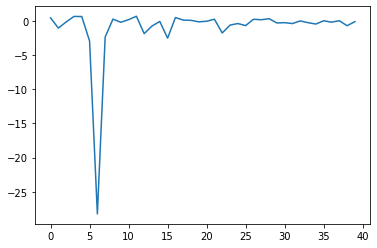

In [ ]:
plt.plot(x, final_r2_lst)

In [ ]:
def average_r2(lst):
    return np.array([sum(i) for i in zip(*lst)]) / len(final_r2_val_list[0])

def final_r2(x):
    first_lst = []
    final_r2_list = []
    for i in x:
        if len(i) > 1:
            first_lst.append(i[0])
        else:
            first_lst.append(i)
    for j in first_lst:
        final_r2_list.append(j)
    return final_r2_list

In [ ]:
def delete_lst(x):
    new_lst  = []
    for i in x:
        if type(i) is list:
            for item in i:
                new_lst.append(item)
        else: 
            new_lst.append(i)
    return new_lst

#### Creating list with accuracies and filling

In [ ]:
final_r2_val_bianchi = [[[] for k in range(len(all_splits))] for q in range(6)]
final_r2_test_list = [[[] for k in range(len(all_splits))] for q in range(6)]
final_r2_bianchi = [[[] for k in range(len(all_splits))] for q in range(6)]
final_sign = [[[] for k in range(len(all_splits))] for q in range(6)]
testertje = [[[] for k in range(len(all_splits))] for q in range(6)]

In [ ]:
for j in range(6):
    for i in range(len(all_splits)):
        final_r2_val_bianchi[j][i] = R2_Bianchi_val[j][i]
        final_r2_bianchi[j][i] = R2_Bianchi[j][i]
        final_sign[j][i] = significance_list[j][i]

In [ ]:
len(R2_Bianchi_val[0][0])

288

In [ ]:
max_val = max(R2_Bianchi_val[0][0])
max_index =  R2_Bianchi_val[0][0].index(max_val)

In [ ]:
R2_Bianchi[0][0]

[-0.343062933829841,
 -0.32027864745266954,
 -0.3126212133689912,
 -0.30935435463193506,
 -0.3072694616001588,
 -0.30802709790203875,
 -0.27028314342408377,
 -0.20971217771970974,
 -0.1161527190188838,
 0.4886770980392596,
 0.3192492536582433,
 0.3525556619925768,
 0.3810527383833118,
 0.3853448608164498,
 0.441240905360729]

### Delete the list

In [ ]:
for j in range(1):
    final_r2_val_bianchi[j] = delete_lst(final_r2(final_r2_val_bianchi[j]))
    #final_r2_test_list[j] = delete_lst(final_r2(final_r2_test_list[j]))
    final_r2_bianchi[j] = delete_lst(final_r2(final_r2_bianchi[j]))
    final_sign[j] = delete_lst(final_r2(final_sign))

### Validation Plot

In [ ]:
X = range(len(final_r2_val_bianchi[0]))

In [ ]:
Y_plot_val = [[[] for k in range(len(all_splits))] for q in range(6)]
for i in range(6):
    Y_plot_val[i] = final_r2_val_bianchi[i] 
    

In [ ]:
# for i in range(6):
#     plt.plot(X, Y_plot_val[i])

In [ ]:
for j in range(1):
    #final_r2_val_bianchi[j] = delete_lst(final_r2_val_bianchi[j])
    print('R2 =', sum(final_r2_val_bianchi[j]) / len(final_r2_val_bianchi[j]))

TypeError: unsupported operand type(s) for +: 'int' and 'list'

In [ ]:
Y_plot_Bianchi = [[[] for k in range(len(all_splits))] for q in range(6)]

for i in range(6):
    Y_plot_Bianchi[i] = final_r2_bianchi[i]

In [ ]:
final_r2_bianchi

[[-0.057671024979904395], [], [], [], [], []]

In [ ]:
# for i in range(6):
#     plt.plot(X, Y_plot_Bianchi[i])
    

#### R2 Bianchi

In [ ]:
for i in range(1):
    print('R2 =', sum(final_r2_bianchi[i]) / len(final_r2_bianchi[i]))

R2 = -0.6874759882548191


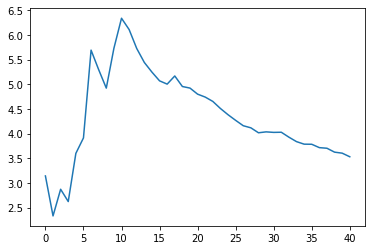

In [ ]:
x = range(len(losses[0]))
y = losses[0]
plt.plot(x,y)

In [ ]:
print(sum(final_sign[0]) / len(final_sign[0]))

0.6841575590534263
